In [1]:
import copy
import os
import sys
from copy import deepcopy

import numpy as np
from jupyter_client.adapter import adapters

from finetuning.bert_masking import BertPreTrainedModel_masking
%load_ext autoreload
%autoreload 2

import tqdm
import math
import numpy as np

from datasets import load_dataset
import transformers
from transformers import AutoTokenizer, AutoModel, BertConfig, AutoModelForCausalLM, BertPreTrainedModel
from torch.optim import AdamW
from transformers import get_scheduler
from peft import LoraConfig, PeftModel

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import loralib

# Masking

In [2]:
# Now lets create the torch Dataset class
class IMDBClassificationDataset(Dataset):
    def __init__(self, datasets, lora_cnt=2, id=None):
        self.datasets = datasets
        self.id = id
        self.lora_cnt = lora_cnt

    def __len__(self):
        if self.id is not None:
            return len(self.datasets[self.id])
        else:
            return sum([len(d) for d in self.datasets])

    def __getitem__(self, idx):
        masking = torch.zeros(self.lora_cnt)
        
        if self.id is not None:
            masking[self.id] = 1    
            d = self.datasets[self.id][idx]
        else:
            masking[idx % self.lora_cnt] = 1
            d = self.datasets[idx % self.lora_cnt][idx // self.lora_cnt]
        
        ids = torch.tensor(d['input_ids'])
        mask = torch.tensor(d['attention_mask'])
        label = torch.tensor(d['label'])
        
        return ids, mask, label, masking

In [3]:
# setting device to `cuda` if gpu exists
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# initialising the model
bert = AutoModel.from_pretrained("google/bert_uncased_L-2_H-128_A-2", device_map="auto")
# bert = BertPreTrainedModel_masking.from_pretrained("google/bert_uncased_L-2_H-128_A-2", device_map="auto")

In [4]:
def get_size_of_model(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    
    return (param_size + buffer_size) / 1024**2

In [5]:
bert_size = get_size_of_model(bert)
# print('model size: {:.3f}MB'.format(bert_size))

In [6]:
sizes = []
sizes_full = []
sizes.append({"model": "bert", "size": bert_size})
sizes_full.append({"model": "bert", "size": bert_size})

In [7]:
from custom_model import CustomBert, LoRABert

for i in range(1, 5):
    model_my = CustomBert(copy.deepcopy(bert), num_adapters=i)
    models_LoRA = [LoRABert(copy.deepcopy(bert)) for _ in range(i)]
    sizes.append({"model": f"bert_{i}", "size": get_size_of_model(model_my)})
    sizes_full.append({"model": f"bert_{i}", "size": sum([get_size_of_model(model) for model in models_LoRA])})

C:\Users\balanton\anaconda3\envs\mnlp_m2\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


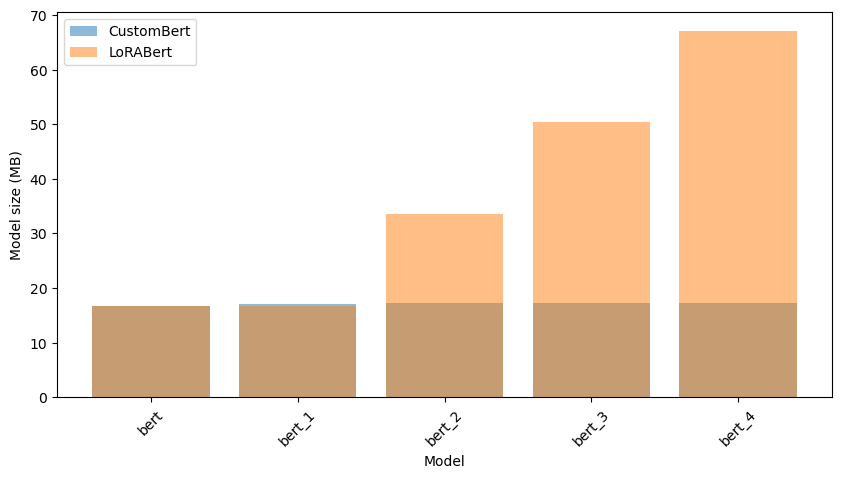

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

df_1 = pd.DataFrame(sizes)
df_2 = pd.DataFrame(sizes_full)

plt.figure(figsize=(10, 5))
# show histogram of model sizes for each model name for both models, add opasity to the bars
plt.bar(df_1["model"], df_1["size"], label="CustomBert", alpha=0.5)
plt.bar(df_2["model"], df_2["size"], label="LoRABert", alpha=0.5)
plt.legend()
plt.ylabel("Model size (MB)")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.show()

In [9]:
# Define LoRA parameters
rank = 8
num_adapters = 2

from custom_model import CustomBert, LoRABert
# Initialize the custom model
model = CustomBert(copy.deepcopy(bert), num_adapters=num_adapters).to(device)

C:\Users\balanton\anaconda3\envs\mnlp_m2\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [10]:
tokenizer = AutoTokenizer.from_pretrained("google/bert_uncased_L-2_H-128_A-2")

def tokenize_imdb(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

def tokenize_sst2(examples):
    return tokenizer(examples["sentence"], padding="max_length", truncation=True, max_length=128)

def get_tokenized_datasets(paths, functions, split="train", batched=True, num_samples=1000):
    datasets = [load_dataset(path) for path in paths]
    tokenized_datasets = [dataset.map(function, batched=batched)[split].shuffle(seed=42).select(range(num_samples)) for dataset, function in zip(datasets, functions)]
    return tokenized_datasets

def get_dataloaders(tokenized_datasets, lora_cnt, split="train", batch_size=8):
    if split=="train":
        dataset = IMDBClassificationDataset(tokenized_datasets, lora_cnt=lora_cnt)
        return [DataLoader(dataset, shuffle=True, batch_size=batch_size)]
    elif split=="test":
        datasets = [IMDBClassificationDataset(tokenized_datasets, lora_cnt=lora_cnt, id=i) for i in range(lora_cnt)]
        return [DataLoader(dataset, shuffle=False, batch_size=batch_size) for dataset in datasets]
    else:
        raise ValueError("Invalid split")

In [7]:
imdb_dataset = load_dataset("imdb")
sst2_dataset = load_dataset("stanfordnlp/sst2")

tokenized_imdb = imdb_dataset.map(tokenize_imdb, batched=True)
tokenized_sst2 = sst2_dataset.map(tokenize_sst2, batched=True)

imdb_test = tokenized_imdb["test"].shuffle(seed=42).select(range(1000))
sst2_test = tokenized_sst2["test"].shuffle(seed=42).select(range(1000))

tokenized_test = [imdb_test, sst2_test]

dataset_imdb = IMDBClassificationDataset(tokenized_test, lora_cnt=num_adapters, id=0)
dataset_sst2 = IMDBClassificationDataset(tokenized_test, lora_cnt=num_adapters, id=1)
test_loaders = [DataLoader(dataset_imdb, shuffle=False, batch_size=8), DataLoader(dataset_sst2, shuffle=False, batch_size=8)]

In [8]:
# Evaluate both adapters on respective datasets
# model.eval()
criterion = torch.nn.BCELoss()

for i in range(num_adapters):
    total_loss = 0
    for batch in test_loaders[i]:
        ids, masks, labels, masking = batch
        labels = labels.type(torch.float)
        o = model(ids.to(device), masks.to(device), masking.to(device))
        loss = criterion(torch.squeeze(o), labels.to(device))
        
        total_loss += loss.item()
        
    print(f"Adapter {i} loss: {total_loss / len(test_loaders[i])}")

C:\Users\balanton\anaconda3\envs\mnlp_m2\lib\site-packages\transformers\models\bert\modeling_bert.py:442: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Adapter 0 loss: 0.6939388260841369


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [11]:
tokenized_datasets = get_tokenized_datasets(["imdb", "stanfordnlp/sst2"], [tokenize_imdb, tokenize_sst2], num_samples=1000, split="train")

In [12]:
# Initialize the custom model
model = CustomBert(copy.deepcopy(bert), num_adapters=num_adapters).to(device)

# Mark only LoRA parameters as trainable
loralib.utils.mark_only_lora_as_trainable(model)

# Training loop
model.train()
criterion = torch.nn.BCELoss()
optimizer = AdamW(model.parameters(), lr=5e-5)
train_dataloader = get_dataloaders(tokenized_datasets, num_adapters, split="train")[0]

num_epochs = 10
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

C:\Users\balanton\anaconda3\envs\mnlp_m2\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [13]:
for epoch in tqdm.tqdm(range(num_epochs)):
    for batch in train_dataloader:
        ids, masks, labels, masking = batch
        labels = labels.type(torch.float)
        o = model(ids.to(device), masks.to(device), masking.to(device))

        loss = criterion(torch.squeeze(o), labels.to(device))
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

  0%|          | 0/10 [00:00<?, ?it/s]C:\Users\balanton\anaconda3\envs\mnlp_m2\lib\site-packages\transformers\models\bert\modeling_bert.py:442: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
100%|██████████| 10/10 [00:25<00:00,  2.54s/it]


In [91]:
# save the tokenizer and the model in `./test-model/` directory 
tokenizer.save_pretrained("./test-model/")
model.save_pretrained("./test-model/", push_to_hub=False)

ValueError: You are trying to save a non contiguous tensor: `bert.encoder.layer.0.attention.self.query.linear.weight` which is not allowed. It either means you are trying to save tensors which are reference of each other in which case it's recommended to save only the full tensors, and reslice at load time, or simply call `.contiguous()` on your tensor to pack it before saving.

In [ ]:
from transformers import pipeline

# as this is classification so you need to mention `text-classification` as task
classifier = pipeline('text-classification', model='tanmoyio/test-model')
classifier("This movie was superb")


# Masking
---
# Parallel

In [2]:
# setting device to `cuda` if gpu exists
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# initialising the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("google/bert_uncased_L-2_H-128_A-2")
bert = AutoModel.from_pretrained("google/bert_uncased_L-2_H-128_A-2", device_map="auto")
# bert = BertPreTrainedModel_masking.from_pretrained("google/bert_uncased_L-2_H-128_A-2", device_map="auto")

# Define LoRA parameters
rank = 8
num_adapters = 2

C:\Users\balanton\anaconda3\envs\mnlp_m2\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [3]:
# initialising the tokenizer
tokenizer = AutoTokenizer.from_pretrained("google/bert_uncased_L-2_H-128_A-2")

def tokenize_imdb(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

def tokenize_sst2(examples):
    return tokenizer(examples["sentence"], padding="max_length", truncation=True, max_length=128)

# Now lets create the torch Dataset class
class IMDBClassificationDataset(Dataset):
    def __init__(self, datasets, lora_cnt=2, id=None):
        self.datasets = datasets
        self.id = id
        self.lora_cnt = lora_cnt

    def __len__(self):
        if self.id is not None:
            return len(self.datasets[self.id])
        else:
            return sum([len(d) for d in self.datasets])

    def __getitem__(self, idx):
        masking = torch.zeros(self.lora_cnt)
        
        if self.id is not None:
            masking[self.id] = 1    
            d = self.datasets[self.id][idx]
        else:
            masking[idx % self.lora_cnt] = 1
            d = self.datasets[idx % self.lora_cnt][idx // self.lora_cnt]
        
        ids = torch.tensor(d['input_ids'])
        mask = torch.tensor(d['attention_mask'])
        label = torch.tensor(d['label'])
        
        return ids, mask, label, masking

C:\Users\balanton\anaconda3\envs\mnlp_m2\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [4]:
import concurrent


class ParallelTrainer:
    def __init__(self, model, device, num_adapters=2):
        self.model = model
        self.device = device
        self.num_adapters = num_adapters             
    
    def train_model(self, train_dataloader, num_epochs=3):
        # model.train()
        criterion = torch.nn.BCELoss()
        optimizer = AdamW(model.parameters(), lr=5e-5)
        num_training_steps = num_epochs * len(train_dataloader)
        lr_scheduler = get_scheduler(
            "linear",
            optimizer=optimizer,
            num_warmup_steps=0,
            num_training_steps=num_training_steps
        )

        for epoch in tqdm.tqdm(range(num_epochs)):
            for batch in train_dataloader:
                ids, masks, labels, masking = batch
                labels = labels.type(torch.float32)
                o = model(ids.to(device), masks.to(device), masking.to(device))
                loss = criterion(torch.squeeze(o), labels.to(device))
                loss.backward()

                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad() 
                
    def train(self, train_dataloaders, num_epochs=3):
        model.train()
        with concurrent.futures.ThreadPoolExecutor() as executor:
            futures = [executor.submit(self.train_model, dataloader, num_epochs) for dataloader in train_dataloaders]
            concurrent.futures.wait(futures)

In [5]:
from custom_model import CustomBert

model = CustomBert(copy.deepcopy(bert), num_adapters=num_adapters).to(device)

loralib.utils.mark_only_lora_as_trainable(model)

# Initialize the parallel trainer
trainer = ParallelTrainer(model, device, num_adapters=num_adapters)

In [6]:
imdb_dataset = load_dataset("imdb")
sst2_dataset = load_dataset("stanfordnlp/sst2")

tokenized_imdb = imdb_dataset.map(tokenize_imdb, batched=True)
tokenized_sst2 = sst2_dataset.map(tokenize_sst2, batched=True)

tokenized_imdb = tokenized_imdb["train"].shuffle(seed=42).select(range(1000))
tokenized_sst2 = tokenized_sst2["train"].shuffle(seed=42).select(range(1000))

tokenized_datasets = [tokenized_imdb, tokenized_sst2]

dataset_imdb = IMDBClassificationDataset(tokenized_datasets, lora_cnt=num_adapters, id=0)
dataset_sst2 = IMDBClassificationDataset(tokenized_datasets, lora_cnt=num_adapters, id=1)
test_loaders = [DataLoader(dataset_imdb, shuffle=False, batch_size=8), DataLoader(dataset_sst2, shuffle=False, batch_size=8)]

In [ ]:
trainer.train(test_loaders, num_epochs=3)


  0%|          | 0/3 [00:00<?, ?it/s]C:\Users\balanton\anaconda3\envs\mnlp_m2\lib\site-packages\transformers\models\bert\modeling_bert.py:442: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
